In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Homework 4: Let's simulate a microscope

The goal of this homework assignment is to create a physically accurate simulation of an optical microscope. This should give you an idea of how to treat an imaging system as a black box linear system, by performing filtering in the Fourier domain. This type of model is also applicable to imaging with other EM radiation, ultrasound, MRI, CT etc.

This simulation will: 

1. Illuminate a thin sample (with finite thickness variations) with light from a particular angle
2. The emerging light will then propagate from the sample to the microscope lens,
3. The light will be filtered by the microscope lens, 
4. And then will continue to the image sensor and will be detected by the image sensor.

Because things are small within a microscope, you have to treat light as a wave. So, we'll be defining the sample, illumination and lens effects as complex-valued vectors.

As a first step, you should define all of the variables of interest and an (x,y) coordinate system for the sample. The variables will include the size of the sample, which we can make 0.25 mm (this is a normal size for a microscope sample). To model the object in the computer, we will need to form a discretized representation of the sample. Thanks to the sampling theorem, that is easily doable. While the composition of the sample can contain any sized feature, down to the sub-nanometer scale, the smallest feature that we'll be able to observe optically with the microscope is limited by the wavelength of light (this is a fundamental pysical limit). Accordingly, when we go about discretizing the sample, the smallest feature that we'll be able to see within the simulated sample, $\Delta x$, will be set at half the wavelength of light.

Let's assume the wavelength of light that we'll use is $\lambda$=0.5 $\mu$m (which is greenish light). We can then select the number of discrete elements to split the sample up into as 1000. You can use the np.linspace function to create x and y axes, and the np.meshgrid function to generate a 2D array of x and y values that will be useful later.

In [2]:
wavelength = .5e-3          # units are mm
delta_x = 0.5*wavelength
num_samples = 1000

# Define the spatial coordinates of the sample
starting_coordinate = (-num_samples/2) * delta_x
ending_coordinate = (num_samples/2 - 1) * delta_x

# make linspace, meshgrid coordinates as needed
x = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
y = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
xx, yy = np.meshgrid(x, y)

Next, read in an image to use as the test sample. We have included a test target image that is useful to check the resolution of the microscope with. In addition to simulating a sample with this image, please feel free to also use another image of your choice to create a simulated sample. 

For the assignment, please use the test target image to simulate two different types of sample: one that has both absorption and phase delay (as in the code below), and then later for question (c), one that is only absorptive.

The sample_phase definition deserves a bit of explanation. As explained in class, the phase represents the optical thickness of the specimen. Since it is not easy to find datasets of aborption and optical thickness, here we'll just use an image that represents absorption, and then make an approximation to estimate its optical thickness. We will assume that the sample's optical thickness is directly proportional to how much light is absorbed (hope it is clear from the equation why that is the case!)  

In [3]:
from PIL import Image
import requests
from io import BytesIO

response = requests.get("https://deepimaging.github.io/data/resolution_target.png")
img = Image.open(BytesIO(response.content))
sample = np.array(img)

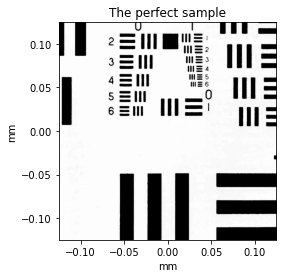

In [4]:
# Define sample absorption
sample = sample/sample.max()
# Add in sample phase delay  
# - assume sample thickness linearly proportional to absorption
sample_phase = 1 - sample
optical_thickness = 20 * wavelength
# complex exponential represents phase delay
sample = sample * np.exp(1j * sample_phase*optical_thickness/wavelength) 

# show absolute value of sample = its absorption
plt.figure()
plt.imshow(np.abs(sample), extent=(x[0], x[-1], y[0], y[-1]))
plt.title('The perfect sample')
plt.xlabel('mm');  plt.ylabel('mm'); plt.gray()

Next, let's model a plane wave hitting this thin sample. I've written down the general form of a plane wave for you guys below. Note that you can simulate the plane wave hit the sample at a desired angle ($\theta_x$,$\theta_y$).

In [5]:
# Define plane wave
plane_wave_angle_x = 0 * np.pi/180
plane_wave_angle_y = 0 * np.pi/180
illumination_plane_wave = np.exp(1j*2*np.pi/wavelength * (np.sin(plane_wave_angle_x) * xx + np.sin(plane_wave_angle_y) * yy))

# print(illumination_plane_wave)

# Define field emerging from sample
emerging_field = np.multiply(illumination_plane_wave, sample)

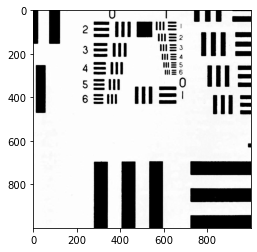

In [6]:
plt.imshow(np.abs(emerging_field))

Now, let's propagate this field to the lens aperture plane via a Fourier transform, to create the sample spectrum. It is also helpful to define a set of coordinates $(f_x,f_y)$ at this Fourier transform plane. You can use the $(x,y)$ coordinates that you formed above, as well as the relationship $2f_x^{max}=1/\Delta x$, to define the $(f_x,f_y)$ coordinates. That is,  the full range of the spatial frequency axis is inversely proportional to the smallest step size in the spatial axis. And plot the magnitude of the sample spectrum with a set of marked and labeled axes (like for the sample in space). It is helpful to plot it on a log scale for visualization.

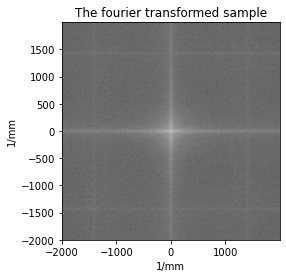

In [7]:
# define total range of spatial frequency axis, 1/mm
f_range = int(1/delta_x)
num_samples =  1000
delta_fx = f_range/num_samples

# make linspace, meshgrid as needed
starting_coordinate = (-num_samples/2) * delta_fx
ending_coordinate = (num_samples/2 - 1) * delta_fx
xf = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
yf = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
xxf, yyf = np.meshgrid(xf, yf)

# Take 2D fourier transform of sample
fourier_field = np.fft.fftshift(np.fft.fft2(emerging_field))

# plot the Fourier transform of the sample in inverse mm coordinates
plt.figure()
plt.imshow(np.log(np.abs(fourier_field)), extent=(xf[0], xf[-1], yf[0], yf[-1]))
plt.title('The fourier transformed sample')
# plt.xscale("log"); plt.yscale("log")
plt.xlabel('1/mm');  plt.ylabel('1/mm'); plt.gray()

Next, define the lens transfer function as a circle with a finite radius in the spatial frequency domain. Inside the circle the value of the transfer function is 1, and outside it is 0. Let's make the lens transfer function diameter 1/4th the total spatial frequency axis coordinates. The diameter is set by a parameter called the lens numerical aperture. 

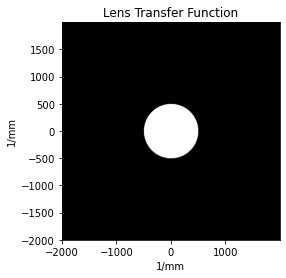

In [8]:
# Define lens numerical aperture as percentage of total width of spatial freqeuncy domain
d =int((ending_coordinate - starting_coordinate+1) / 4)
r = d/2

# Define lens transfer function as matrix with 1's within desired radius, 0's outside
trans = np.zeros((num_samples, num_samples))
dist = np.sqrt((xxf)**2+(yyf)**2)
trans[np.where(dist<r)]=1

# Plot what the transfer function looks like
plt.figure()
plt.imshow(np.abs(trans), extent=(xf[0], xf[-1], yf[0], yf[-1]))
plt.title('Lens Transfer Function')
plt.xlabel('1/mm');  plt.ylabel('1/mm'); plt.gray()

You can now filter the sample spectrum with the lens transfer function, propagate this filtered spectrum to the image plane, and sample it on a detector that only detects the intensity of light, as we've shown in class. Let's assume the magnification of the lens is 5X (meaning the image of the sample at the detector plane is 5X larger than it is at the lens plane). And display the resulting image on a new coordinate system, $(x',y')$ which represent the coordinates at the detector plane.

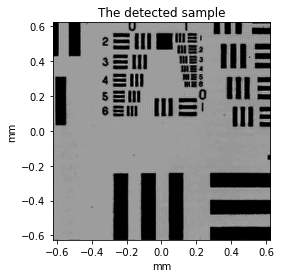

In [9]:
# Create filtered sample spectrum
filtered_sample = np.multiply(fourier_field, trans)

# Define spatial coordinates at image plane, using magnification
starting_coordinate = (-num_samples/2) * delta_x * 5
ending_coordinate = (num_samples/2 - 1) * delta_x * 5

# make linspace, meshgrid coordinates as needed
x_prime = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
y_prime = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
xx_prime, yy_prime = np.meshgrid(x_prime, y_prime)

# Propagate filtered sample spectrum to image plane
inverse_fourier_field = np.fft.ifft2(np.fft.ifftshift(filtered_sample))

# Detect intensity (squared magnitude) of resulting field on sensor
detected_field = np.square(np.abs(inverse_fourier_field))

# Plot resulting image
plt.figure()
plt.clf()
plt.imshow(detected_field, extent=(x_prime[0], x_prime[-1], y_prime[0], y_prime[-1]))
plt.title('The detected sample')
plt.xlabel('mm');  plt.ylabel('mm'); plt.gray()

Ok, we've simulated a microscope image! Great! Now let's try to change a few parameters to see what happens. Please try out the following tests and briefly answer the following questions:

(a) Let's try changing the illumination angle by 5 degrees in x coordinate. What happens to sample spectrum at the aperture plane? Why does that change the appearance of the image? 

(b) Try again with a larger angle of illumination that changes the appearance of the image dramatically, such that the background of the image becomes black. This is called a "dark-field" image. Why is there a transition from an image with a bright background to a dark background, and under what illumination angle conditions does this occur?

(c) Let's change the lens numerical aperture with 0 angles of illumination. Instead of a circle having a diameter that is 25% the width of the frequency domain, let's try a smaller lens with a lens diameter that is 10% of the width of the frequency domain. How does the appearance of the image change? And why?

(d) Next, let's try a wider lens with 50%. Describe how the appearance of the image changes and why. 

(e) The lens aperture does not have to be a circle - it can be whatever shape you want. Go ahead and add an "apodizer" into the lens, which is (literally) a black circle marked onto the center of the lens. You can model this dark circle by making the center of the lens aperture circle zero, up to some first radius, then the lens aperture is 1 up to some second radius, and then the lens aperture ends and everything is zero again (this will form a ring). How does the appearance of the resulting image change, and why? Still do not change the angle of illumination.

# (a)

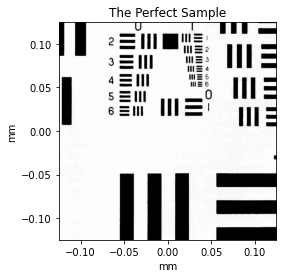

In [10]:
# First load up the image
from PIL import Image
import requests
from io import BytesIO

response = requests.get("https://deepimaging.github.io/data/resolution_target.png")
img = Image.open(BytesIO(response.content))
sample = np.array(img)

wavelength = .5e-3          # units are mm
delta_x = 0.5*wavelength
num_samples = 1000

# Define the spatial coordinates of the sample
# code here
starting_coordinate = (-num_samples/2) * delta_x 
ending_coordinate = (num_samples/2 - 1) * delta_x

# make linspace, meshgrid coordinates as needed
# code here
x = np.linspace(starting_coordinate, ending_coordinate, num = num_samples)
y = np.linspace(starting_coordinate, ending_coordinate, num = num_samples)
xx, yy = np.meshgrid(x, y)

# Define sample absorption
# code here
sample = sample / sample.max()

# Add in sample phase delay  - assume sample thickness linearly proportional to absorption
# code here
sample_phase = 1 - sample
optical_thickness = 20 * wavelength

# complex exponential represents phase delay
sample = sample * np.exp(1j * sample_phase * optical_thickness / wavelength)
# show absolute value of sample = its absorption
plt.figure()
plt.imshow(np.abs(sample), extent = (x[0], x[-1], y[0], y[-1]))
plt.title("The Perfect Sample")
plt.xlabel("mm"); plt.ylabel("mm"); plt.gray()

In [11]:
# Change incident angle 5 degrees in x direction
# code here
# Define plane wave
plane_wave_angle_x = (0 + 5) * np.pi/180
plane_wave_angle_y = 0 * np.pi/180
illumination_plane_wave = np.exp(1j * 2 * np.pi / wavelength * (np.sin(plane_wave_angle_x) * xx + np.sin(plane_wave_angle_y) * yy))

# Define field emerging from sample
emerging_field = np.multiply(illumination_plane_wave, sample)

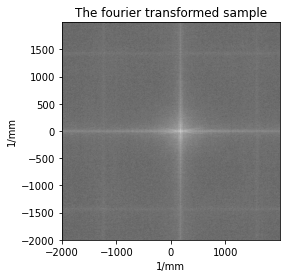

In [12]:
# define total range of spatial frequency axis, 1/mm
# code here
f_range = int(1 / delta_x)
num_samples = 1000
delta_fx = f_range / num_samples

# make linspace, meshgrid as needed
# code here
starting_coordinate = (-num_samples/2) * delta_fx
ending_coordinate = (num_samples/2 - 1) * delta_fx
xf = np.linspace(starting_coordinate, ending_coordinate, num = num_samples)
yf = np.linspace(starting_coordinate, ending_coordinate, num = num_samples)

# Take 2D fourier transform of sample
# code here
fourier_field = np.fft.fftshift(np.fft.fft2(emerging_field))

# plot the Fourier transform of the sample in inverse mm coordinates
plt.figure()
plt.imshow(np.log(np.abs(fourier_field)), extent=(xf[0], xf[-1], yf[0], yf[-1]))
plt.title('The fourier transformed sample')
#plt.xscale("log"); plt.yscale("log")
plt.xlabel('1/mm');  plt.ylabel('1/mm'); plt.gray()

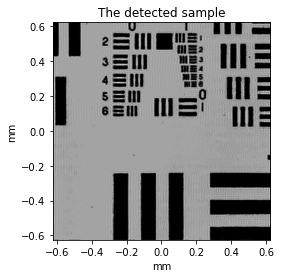

In [13]:
# Define lens numerical aperture as percentage of total width of spatial freqeuncy domain
# code here
d = int((ending_coordinate - starting_coordinate) / 4)
r = d / 2

# Define lens transfer function as matrix with 1's within desired radius, 0's outside
# code here
trans = np.zeros((num_samples, num_samples))
dist = np.sqrt((xxf)**2 + (yyf)**2)
trans[np.where(dist<r)] = 1
# plt.figure()
# plt.imshow(np.abs(trans), extent = (xf[0], xf[-1], yf[0], yf[-1]))
# plt.title("Lens Transfer Function")
# plt.xlabel("1/mm"); plt.ylabel("1/mm"); plt.gray()

# Create filtered sample spectrum
# code here
filtered_sample = np.multiply(fourier_field, trans)

# Define spatial coordinates at image plane, using magnification
# code here
starting_coordinate = (-num_samples/2) * delta_x * 5
ending_coordinate = (num_samples/2 - 1) * delta_x * 5

# make linspace, meshgrid coordinates as needed
# code here
x_prime = np.linspace(starting_coordinate, ending_coordinate, num = num_samples)
y_prime = np.linspace(starting_coordinate, ending_coordinate, num = num_samples)
xx_prime, yy_prime = np.meshgrid(x_prime, y_prime)

# Propagate filtered sample spectrum to image plane
# code here
inverse_fourier_field = np.fft.ifft2(np.fft.ifftshift(filtered_sample))

# Detect intensity (squared magnitude) of resulting field on sensor
# code here
detected_field = np.square(np.abs(inverse_fourier_field))

# Plot resulting image
plt.figure()
plt.clf()
plt.imshow(detected_field, extent=(x_prime[0], x_prime[-1], y_prime[0], y_prime[-1]))
plt.title('The detected sample')
plt.xlabel('mm');  plt.ylabel('mm'); plt.gray()

In [14]:
################################################################################################

### (a) Question: What happens to sample spectrum at the aperture plane?

Answer: As the sample spectrum magnitude plot shows, at the aperture plane, the zero-frequency component (or the center of the sample spectrum) shifts (or moves toward the positive direction) a little bit along the x-axis, which is based on the shifting theorem of Fourier transforms.

### (a) Question: Why does that change the appearance of the image?

Answer: The sample spectrum center (or the zero-frequency component) shifts a little bit along the x-axis, but the lens transfer function still has all 1s' circle located at the (x=0, y=0) origin, and all 0s outside the circle. Therefore, the filtered sample spectrum does not have evenly distributed high/low frequencies along x coordinate. In specific, since low frequencies converge in the center and high frequencies spread around after np.fft.fftshift, we lose more low frequency information on the x-axis positive direction, and keep more high frequency information on the x-axis negative direction. This explains why the resulting image in the detected field has less resolution and less contrast compared with 0-angle illumination. 

In [15]:
#################################################################################################

# (b)

In this section I tried 2 illumination angles in x coordinate to show the transition from an image with a bright background to a dark background.  
Firstly, as shown below, when illumination angle in x coordinate is 14, we can still see the distorted bright background.

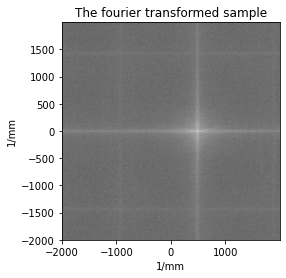

In [16]:
# Change incident angle different angles in x direction to see what angle gives dark background
# Define plane wave
# code here
# between 14 and 15 x angles
plane_wave_angle_x = (0 + 14) * np.pi/180
plane_wave_angle_y = 0 * np.pi/180
illumination_plane_wave = np.exp(1j * 2 * np.pi / wavelength * (np.sin(plane_wave_angle_x) * xx + np.sin(plane_wave_angle_y) * yy))

# define total range of spatial frequency axis, 1/mm
# code here
f_range = int(1 / delta_x)
num_samples = 1000
delta_fx = f_range / num_samples

# make linspace, meshgrid as needed
# code here
starting_coordinate = (-num_samples/2) * delta_fx
ending_coordinate = (num_samples/2 - 1) * delta_fx
xf = np.linspace(starting_coordinate, ending_coordinate, num = num_samples)
yf = np.linspace(starting_coordinate, ending_coordinate, num = num_samples)

# Define field emerging from sample
# code here
emerging_field = np.multiply(illumination_plane_wave, sample)

# Take 2D fourier transform of sample
# code here
fourier_field = np.fft.fftshift(np.fft.fft2(emerging_field))

# plot the Fourier transform of the sample in inverse mm coordinates
plt.figure()
plt.clf()
plt.imshow(np.log(np.abs(fourier_field)), extent=(xf[0], xf[-1], yf[0], yf[-1]))
plt.title('The fourier transformed sample')
#plt.xscale("log"); plt.yscale("log")
plt.xlabel('1/mm');  plt.ylabel('1/mm'); plt.gray()

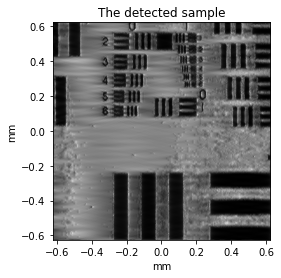

In [17]:
# Define lens numerical aperture as percentage of total width of spatial freqeuncy domain
# code here
d = int((ending_coordinate - starting_coordinate) / 4)
r = d / 2

# Define lens transfer function as matrix with 1's within desired radius, 0's outside
# code here
trans = np.zeros((num_samples, num_samples))
dist = np.sqrt((xxf)**2 + (yyf)**2)
trans[np.where(dist<r)] = 1

# Create filtered sample spectrum
# code here
filtered_sample = np.multiply(fourier_field, trans)

# Propagate filtered sample spectrum to image plane
# code here
inverse_fourier_field = np.fft.ifft2(np.fft.ifftshift(filtered_sample))

# Detect intensity (squared magnitude) of resulting field on sensor
# code here
detected_field = np.square(np.abs(inverse_fourier_field))

# Plot resulting image
plt.figure()
plt.clf()
plt.imshow(detected_field, extent=(x_prime[0], x_prime[-1], y_prime[0], y_prime[-1]))
plt.title('The detected sample')
plt.xlabel('mm');  plt.ylabel('mm'); plt.gray()

Secondly, as shown below, when illumination angle in x coordinate is 15, we can see the dark/black background.

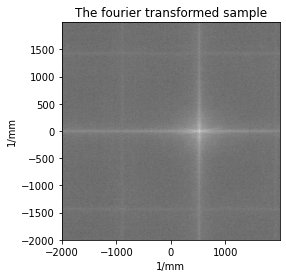

In [18]:
# Change incident angle different angles in x direction to see what angle gives dark background
# Define plane wave
# code here
# between 14 and 15 x angles
plane_wave_angle_x = (0 + 15) * np.pi/180
plane_wave_angle_y = 0 * np.pi/180
illumination_plane_wave = np.exp(1j * 2 * np.pi / wavelength * (np.sin(plane_wave_angle_x) * xx + np.sin(plane_wave_angle_y) * yy))

# define total range of spatial frequency axis, 1/mm
# code here
f_range = int(1 / delta_x)
num_samples = 1000
delta_fx = f_range / num_samples

# make linspace, meshgrid as needed
# code here
starting_coordinate = (-num_samples/2) * delta_fx
ending_coordinate = (num_samples/2 - 1) * delta_fx
xf = np.linspace(starting_coordinate, ending_coordinate, num = num_samples)
yf = np.linspace(starting_coordinate, ending_coordinate, num = num_samples)

# Define field emerging from sample
# code here
emerging_field = np.multiply(illumination_plane_wave, sample)

# Take 2D fourier transform of sample
# code here
fourier_field = np.fft.fftshift(np.fft.fft2(emerging_field))

# plot the Fourier transform of the sample in inverse mm coordinates
plt.figure()
plt.clf()
plt.imshow(np.log(np.abs(fourier_field)), extent=(xf[0], xf[-1], yf[0], yf[-1]))
plt.title('The fourier transformed sample')
#plt.xscale("log"); plt.yscale("log")
plt.xlabel('1/mm');  plt.ylabel('1/mm'); plt.gray()

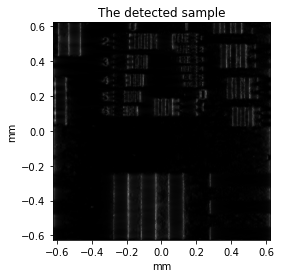

In [19]:
# Define lens numerical aperture as percentage of total width of spatial freqeuncy domain
# code here
d = int((ending_coordinate - starting_coordinate) / 4)
r = d / 2

# Define lens transfer function as matrix with 1's within desired radius, 0's outside
# code here
trans = np.zeros((num_samples, num_samples))
dist = np.sqrt((xxf)**2 + (yyf)**2)
trans[np.where(dist<r)] = 1

# Create filtered sample spectrum
# code here
filtered_sample = np.multiply(fourier_field, trans)

# Propagate filtered sample spectrum to image plane
# code here
inverse_fourier_field = np.fft.ifft2(np.fft.ifftshift(filtered_sample))

# Detect intensity (squared magnitude) of resulting field on sensor
# code here
detected_field = np.square(np.abs(inverse_fourier_field))

# Plot resulting image
plt.figure()
plt.clf()
plt.imshow(detected_field, extent=(x_prime[0], x_prime[-1], y_prime[0], y_prime[-1]))
plt.title('The detected sample')
plt.xlabel('mm');  plt.ylabel('mm'); plt.gray()

In [20]:
###################################################################################################################################

### (b) Question: Why is there a transition from an image with a bright background to a dark background?

Answer: The bright background belongs to low frequency information. In the sample spectrum magnitude plot, low frequency is close to the zero-frequency element or the plot center. If we choose a very large illumination angle in x coordinate, based on the Fourier transforms shifting theorem, we can see that the sample spectrum center shifts a lot along the x-axis. We know the effect of the lens is to block light. When applying the lens transfer function, if the sample spectrum center shifts so much that it goes out of the 1s' circle region and reaches the 0s' outside region, then we will lose a lot of low frequency information, including the bright background. Therefore, we will have even less resolution and even less contrast, which explains why we can only see the dark background in the resulting image.

### (b) Question: Under what illumination angle conditions does this occur?

Answer: When we change the illumination angle in x coordinate from 14 degrees to 15 degrees, this transition occurs.

In [21]:
####################################################################################################################################

# (c)

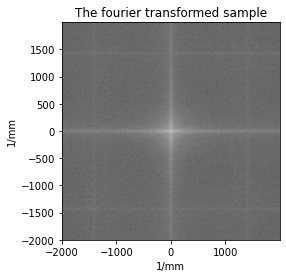

In [22]:
# Define plane wave
# code here
plane_wave_angle_x = 0 * np.pi/180
plane_wave_angle_y = 0 * np.pi/180
illumination_plane_wave = np.exp(1j * 2 * np.pi / wavelength * (np.sin(plane_wave_angle_x) * xx + np.sin(plane_wave_angle_y) * yy))

# define total range of spatial frequency axis, 1/mm
# code here
f_range = int(1 / delta_x)
num_samples = 1000
delta_fx = f_range / num_samples

# make linspace, meshgrid as needed
# code here
starting_coordinate = (-num_samples/2) * delta_fx
ending_coordinate = (num_samples/2 - 1) * delta_fx
xf = np.linspace(starting_coordinate, ending_coordinate, num = num_samples)
yf = np.linspace(starting_coordinate, ending_coordinate, num = num_samples)

# Define field emerging from sample
# code here
emerging_field = np.multiply(illumination_plane_wave, sample)

# Take 2D fourier transform of sample
# code here
fourier_field = np.fft.fftshift(np.fft.fft2(emerging_field))

# plot the Fourier transform of the sample in inverse mm coordinates
plt.figure()
plt.clf()
plt.imshow(np.log(np.abs(fourier_field)), extent=(xf[0], xf[-1], yf[0], yf[-1]))
plt.title('The fourier transformed sample')
#plt.xscale("log"); plt.yscale("log")
plt.xlabel('1/mm');  plt.ylabel('1/mm'); plt.gray()

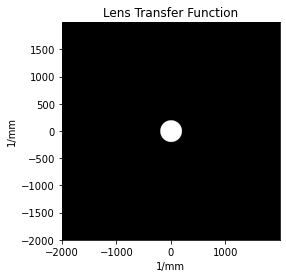

In [23]:
# Define lens numerical aperture as percentage of total width of spatial freqeuncy domain
# code here
d = int((ending_coordinate - starting_coordinate) / 10)
r = d / 2

# Define lens transfer function as matrix with 1's within desired radius, 0's outside
# code here
trans = np.zeros((num_samples, num_samples))
dist = np.sqrt((xxf)**2 + (yyf)**2)
trans[np.where(dist<r)] = 1

# Plot what the transfer function looks like
plt.figure()
plt.imshow(np.abs(trans), extent=(xf[0], xf[-1], yf[0], yf[-1]))
plt.title('Lens Transfer Function')
plt.xlabel('1/mm');  plt.ylabel('1/mm'); plt.gray()

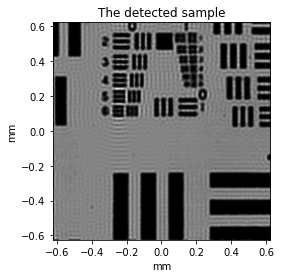

In [24]:
# Create filtered sample spectrum
# code here
filtered_sample = np.multiply(fourier_field, trans)

# Define spatial coordinates at image plane, using magnification
starting_coordinate = (-num_samples/2) * delta_x * 5
ending_coordinate = (num_samples/2 - 1) * delta_x * 5

# make linspace, meshgrid coordinates as needed
x_prime = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
y_prime = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
xx_prime, yy_prime = np.meshgrid(x_prime, y_prime)

# Propagate filtered sample spectrum to image plane
# code here
inverse_fourier_field = np.fft.ifft2(np.fft.ifftshift(filtered_sample))

# Detect intensity (squared magnitude) of resulting field on sensor
# code here
detected_field = np.square(np.abs(inverse_fourier_field))

# Plot resulting image
plt.figure()
plt.clf()
plt.imshow(detected_field, extent=(x_prime[0], x_prime[-1], y_prime[0], y_prime[-1]))
plt.title('The detected sample')
plt.xlabel('mm');  plt.ylabel('mm'); plt.gray()

In [25]:
################################################################################################

### (c) Question: How does the appearance of the image change? And why?

Answer: The resulting image in the detected field has less resolution and less contrast, and we can easily notice the distortions of digits on the detected sample, compared with the original diameter that is 25% of the width of the frequency domain.  
To explain the reason, as the lens transfer function plot shows, now we have a smaller circle with all 1s inside, and more 0s outside. This means we have a stronger de-sampling strength when multiplying the sample spectrum with the lens transfer function. We will lose more high frequency information which explains the distortions of digits, and only the low frequency information near the zero-frequency component center can be kept in the filtered sample spectrum. Therefore, the resulting image has less resolution and less contrast, and the digits (high frequency area) are distorted.

In [26]:
#################################################################################################

# (d)

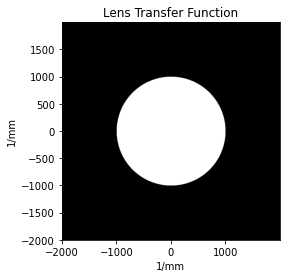

In [27]:
# make linspace, meshgrid as needed
# code here
starting_coordinate = (-num_samples/2) * delta_fx
ending_coordinate = (num_samples/2 - 1) * delta_fx
xf = np.linspace(starting_coordinate, ending_coordinate, num = num_samples)
yf = np.linspace(starting_coordinate, ending_coordinate, num = num_samples)

# Define lens numerical aperture as percentage of total width of spatial freqeuncy domain
# code here
d = int((ending_coordinate - starting_coordinate) / 2)
r = d / 2

# Define lens transfer function as matrix with 1's within desired radius, 0's outside
# code here
trans = np.zeros((num_samples, num_samples))
dist = np.sqrt((xxf)**2 + (yyf)**2)
trans[np.where(dist<r)] = 1

# Plot what the transfer function looks like
plt.figure()
plt.imshow(np.abs(trans), extent=(xf[0], xf[-1], yf[0], yf[-1]))
plt.title('Lens Transfer Function')
plt.xlabel('1/mm');  plt.ylabel('1/mm'); plt.gray()

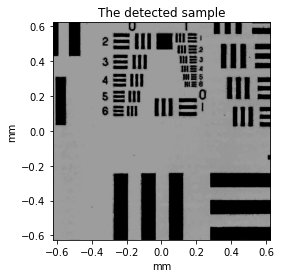

In [28]:
# Create filtered sample spectrum
# code here
filtered_sample = np.multiply(fourier_field, trans)

# Define spatial coordinates at image plane, using magnification
starting_coordinate = (-num_samples/2) * delta_x * 5
ending_coordinate = (num_samples/2 - 1) * delta_x * 5

# make linspace, meshgrid coordinates as needed
x_prime = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
y_prime = np.linspace(starting_coordinate, ending_coordinate, num=num_samples)
xx_prime, yy_prime = np.meshgrid(x_prime, y_prime)

# Propagate filtered sample spectrum to image plane
# code here
inverse_fourier_field = np.fft.ifft2(np.fft.ifftshift(filtered_sample))

# Detect intensity (squared magnitude) of resulting field on sensor
# code here
detected_field = np.square(np.abs(inverse_fourier_field))

# Plot resulting image
plt.figure()
plt.clf()
plt.imshow(detected_field, extent=(x_prime[0], x_prime[-1], y_prime[0], y_prime[-1]))
plt.title('The detected sample')
plt.xlabel('mm');  plt.ylabel('mm'); plt.gray()

In [29]:
#####################################################################################################

### (d) Question: How does the appearance of the image change? And why?

Answer: Compared with (c), now we have higher image resolution and higher image contrast, and we can clearly see the digits on the detected sample.  
To explain the reason, as the lens transfer function plot shows, now we have a larger circle with all 1s inside and less 0s outside. This means we have a weaker de-sampling strength when multiplying the sample spectrum with the lens transfer function, and more (from low to high) frequency information can be kept in the filtered sample spectrum. Therefore, we can see the resulting image in the detected field with higher resolution and higher contrast.

In [30]:
######################################################################################################

# (e)

In [31]:
wavelength = .5e-3          # units are mm
delta_x = 0.5*wavelength
num_samples = 1000

from PIL import Image
import requests
from io import BytesIO

response = requests.get("https://deepimaging.github.io/data/resolution_target.png")
img = Image.open(BytesIO(response.content))
sample = np.array(img)

# Define sample absorption
# code here
sample = sample / sample.max()

# Add in sample phase delay  - assume sample thickness linearly proportional to absorption
# code here
sample_phase = 1 - sample
optical_thickness = 20 * wavelength
# complex exponential represents phase delay
sample = sample * np.exp(1j * sample_phase * optical_thickness / wavelength)

# Define plane wave
# code here
plane_wave_angle_x = 0 * np.pi/180 
plane_wave_angle_y = 0 * np.pi/180 
illumination_plane_wave = np.exp(1j * 2 * np.pi / wavelength * (np.sin(plane_wave_angle_x) * xx + np.sin(plane_wave_angle_y) * yy))

# Define field emerging from sample
# code here
emerging_field = np.multiply(illumination_plane_wave, sample) 

# define total range of spatial frequency axis, 1/mm
# code here
f_range = int(1 / delta_x)
num_samples = 1000
delta_fx = f_range / num_samples

# make linspace, meshgrid as needed
# code here
starting_coordinate = (-num_samples/2) * delta_fx
ending_coordinate = (num_samples/2 - 1) * delta_fx
xf = np.linspace(starting_coordinate, ending_coordinate, num = num_samples)
yf = np.linspace(starting_coordinate, ending_coordinate, num = num_samples)

# Take 2D fourier transform of sample
# code here
fourier_field = np.fft.fftshift(np.fft.fft2(emerging_field))

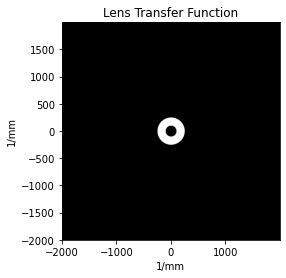

In [32]:
# Define lens numerical aperture as percentage of total width of spatial freqeuncy domain
# code here
d = int((ending_coordinate - starting_coordinate) / 4)
# r = d / 2
radius_first = d / 10
radius_second = d / 4

# Define lens transfer function as matrix with 1's within desired radius, 0's outside
# code here
trans = np.zeros((num_samples, num_samples))
dist = np.sqrt((xxf)**2 + (yyf)**2)
# trans[np.where(dist<r)] = 1
trans[np.where(dist < radius_second)] = 1 
trans[np.where(dist < radius_first)] = 0 

# Plot what the transfer function looks like
plt.figure()
plt.imshow(np.abs(trans), extent=(xf[0], xf[-1], yf[0], yf[-1]))
plt.title('Lens Transfer Function')
plt.xlabel('1/mm');  plt.ylabel('1/mm'); plt.gray()

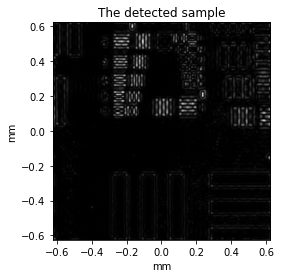

In [33]:
# Create filtered sample spectrum
# code here
filtered_sample = np.multiply(fourier_field, trans)

# Define spatial coordinates at image plane, using magnification
# code here
starting_coordinate = (-num_samples/2) * delta_x * 5
ending_coordinate = (num_samples/2 - 1) * delta_x * 5

# make linspace, meshgrid coordinates as needed
# code here
x_prime = np.linspace(starting_coordinate, ending_coordinate, num = num_samples)
y_prime = np.linspace(starting_coordinate, ending_coordinate, num = num_samples)
xx_prime, yy_prime = np.meshgrid(x_prime, y_prime)

# Propagate filtered sample spectrum to image plane
# code here
inverse_fourier_field = np.fft.ifft2(np.fft.ifftshift(filtered_sample))

# Detect intensity (squared magnitude) of resulting field on sensor
# code here
detected_field = np.square(np.abs(inverse_fourier_field))

# Plot resulting image
plt.figure()
plt.clf()
plt.imshow(detected_field, extent=(x_prime[0], x_prime[-1], y_prime[0], y_prime[-1]))
plt.title('The detected sample')
plt.xlabel('mm');  plt.ylabel('mm'); plt.gray()

In [34]:
############################################################################################################

### (e) Question: How does the appearance of the resulting image change? And why?

Answer: Instead of the originally bright background, now we can see the dark/black background in the resulting image, and we can also see many white lines and significantly distorted digits in the high frequency area.  
To explain the reason, as the lens transfer function plot shows, now we have a white "ring" instead of a white "circle". Now we only have 1s between the first small radius and the second large radius, all 0s are filled in the region smaller than the first radius and larger than the second radius. When multiplying the sample spectrum with the lens transfer function, low frequency information including the bright background and the zero-frequency component center of the sample spectrum will be blocked (or dropped) by the 0s within the first radius of the lens transfer function, and high frequency information will be blocked by the 0s outside the second radius, basically we can only keep information between low and high frequencies. Therefore, the resulting image has less resolution and less contrast, and we can not see the bright background. 

In [35]:
#############################################################################################################